# Challenge Intermedio: Modelo para Predecir la Calidad del Vino

Elaboró: Leon Palomares

Fecha: 15/11/2025

Modelo: Regresión Logistica

Bases de Datos: Wine Quality Dataset


In [66]:
# Imports principales
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


### Iniciamos la Sesion Spark

In [67]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PrediccionCalidadVino')\
        .getOrCreate()

### Importamos las bases de datos:

In [68]:
df1 = spark.read.csv('winequality-red.csv',
                       inferSchema = True,
                       sep=";",
                       header = True)
df2 = spark.read.csv('winequality-white.csv',
                       inferSchema = True,
                       sep=";",
                       header = True)

print(type(df1))
print(type(df2))

print(df1.show(5))
print(df1.printSchema())
print(df2.show(5))
print(df2.printSchema())


<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2| 

### Unificamos datasets

In [69]:
wine = df1.unionByName(df2)
wine.show(5)
wine.printSchema()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [70]:
wine = wine.withColumn(
    'label', 
    (col('quality') >= 6).cast('int')) # Calidad mayor a 6, es clasificado como bueno.

print(wine.show(5))


feature_columns = [col for col in wine.columns if col not in ["quality", "label"]]
print('Columnas seleccionadas: \n', feature_columns)




+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|label|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|    0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|    0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|    0|
|         11.2|            0.28|       0.56|           1.9|    0

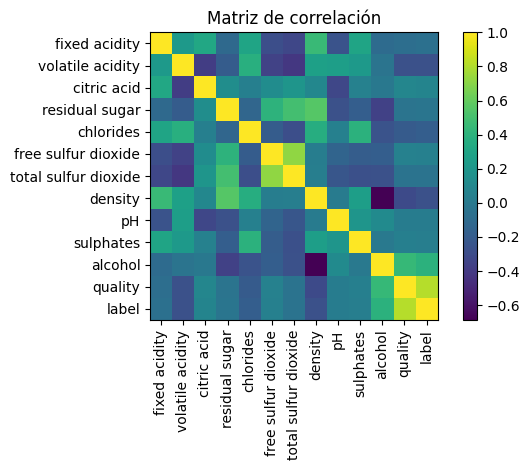

In [82]:
pdf = wine.toPandas()

plt.figure()
corr = pdf.corr()
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

### Uso de transformadores de Spark ML

In [72]:
assem = VectorAssembler(inputCols=feature_columns, outputCol='FeatureUnscaled')
wine = assem.transform(wine)

In [73]:
scale = StandardScaler(inputCol="FeatureUnscaled", outputCol="scaledFeatures")
scaler = scale.fit(wine)
wine = scaler.transform(wine)

### Conjuntos de Entrenamiento y Prueba

In [74]:
train, test = wine.randomSplit([0.82, 0.18], seed=42)

In [75]:
RL = LogisticRegression(featuresCol="scaledFeatures", labelCol="label")
ModeloRL = RL.fit(train)

### Evaluamos Modelo de Regresion Logistica

In [76]:
Eval = ModeloRL.transform(test)

In [77]:
Evaluador = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
DF_RL = Evaluador.evaluate(Eval)
print(f"Área bajo la curva ROC: {DF_RL:.4f}")

Área bajo la curva ROC: 0.8021


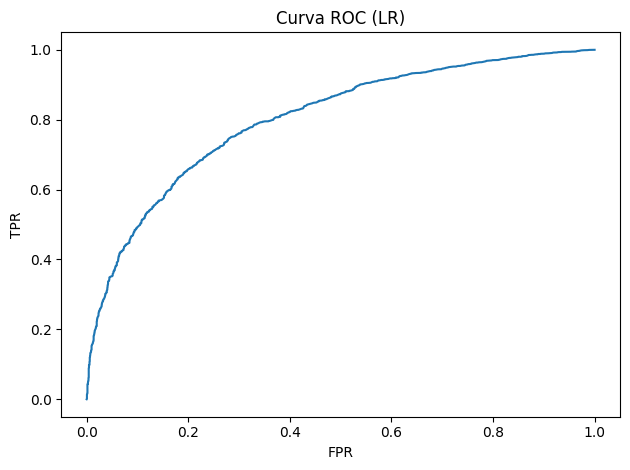

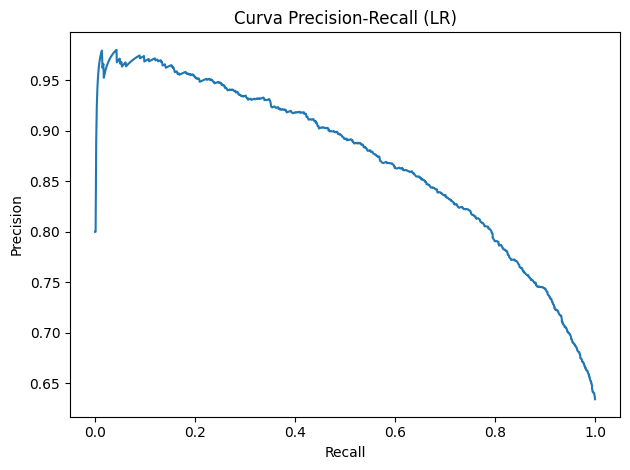

In [84]:
train_summary = ModeloRL.summary
roc_df = train_summary.roc.toPandas()
pr_df = train_summary.pr.toPandas()

# ROC
plt.figure()
plt.plot(roc_df['FPR'], roc_df['TPR'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC (LR)')
plt.tight_layout()
plt.show()

# PR
plt.figure()
plt.plot(pr_df['recall'], pr_df['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (LR)')
plt.tight_layout()
plt.show()

In [78]:
Precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = Precision.evaluate(Eval)
print(f"Exactitud del modelo: {accuracy:.4f}")

Exactitud del modelo: 0.7351


In [79]:
# Mostrar una muestra de las predicciones
Eval.select("label", "prediction", "probability").show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.01262940571872...|
|    1|       1.0|[0.20032736450966...|
|    0|       0.0|[0.75475211789902...|
|    0|       0.0|[0.62452478063029...|
|    1|       1.0|[0.02804415258829...|
+-----+----------+--------------------+
only showing top 5 rows



In [80]:
# Matriz de confusion
Eval.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  110|
|    0|       0.0|  230|
|    1|       1.0|  583|
|    0|       1.0|  183|
+-----+----------+-----+

